In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Functions for simulating TAR model

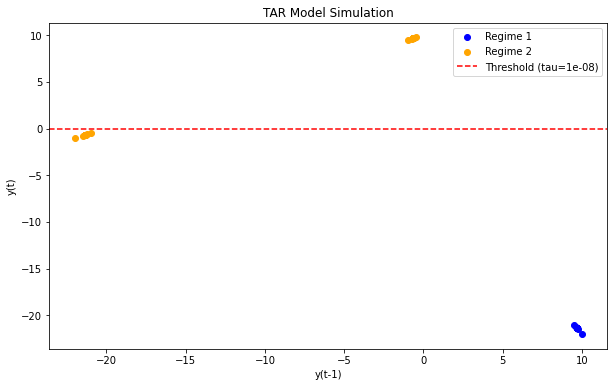

Regime counts: {'Regime_1': 27, 'Regime_2': 13}
Estimated coefficients for Regime 1: [-2. -2.]
Estimated coefficients for Regime 2: [10.   0.5]


In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

def tar_simulation(regime_1, regime_2, N, threshold_func, seed=1, tau=0, sd=0, plot=True):
    """
    Simulates a Threshold Autoregressive (TAR) model with two regimes.

    Parameters:
    - regime_1: Coefficients for the first regime [intercept, AR coefficients].
    - regime_2: Coefficients for the second regime [intercept, AR coefficients].
    - N: Number of observations to simulate.
    - threshold_func: Function to determine the threshold condition.
    - seed: Random seed for reproducibility.
    - tau: Threshold value.
    - sd: Standard deviation of the noise added to the process.
    - plot: Boolean to indicate whether to plot the results.

    Returns:
    - y: Simulated time series data.
    - coef_regime1: Estimated coefficients for regime 1.
    - coef_regime2: Estimated coefficients for regime 2.
    """
    
    # Set random seed for reproducibility
    np.random.seed(seed)
    
    # Determine AR order based on the longest regime
    d = max(len(regime_1) - 1, len(regime_2) - 1)
    
    # Ensure there are enough lags for the threshold function
    max_lag = max(d, 2)
    
    # Initialize time series array with zeros
    y = np.zeros(N + max_lag, dtype=np.float64)
    
    # Initialize counters for each regime
    regime_count = np.zeros(2, dtype=int)
    
    # Dummy variable to track which regime each observation belongs to
    dummy = np.zeros(N, dtype=int)
    
    # Pre-allocate arrays for regime coefficients (reversed order for dot product)
    regime_1_coef = np.array(regime_1[1:][::-1])
    regime_2_coef = np.array(regime_2[1:][::-1])
    
    # Simulate the time series data
    for i in range(max_lag, N + max_lag):
        # Calculate threshold value using custom function
        threshold_value = threshold_func(y[i-2:i][::-1])
        
        # Determine which regime to use based on threshold value
        if threshold_value <= tau + 1e-8:
            new_value = np.dot(y[i-d:i][::-1][:len(regime_1)-1], regime_1_coef) + regime_1[0]
            regime_count[0] += 1
            dummy[i-max_lag] = 1
        else:
            new_value = np.dot(y[i-d:i][::-1][:len(regime_2)-1], regime_2_coef) + regime_2[0]
            regime_count[1] += 1
        
        # Add noise and update time series
        y[i] = new_value + np.random.normal(0, sd)
    
    # Remove initial zero padding
    y = y[max_lag:]
    
    # Prepare data matrix for OLS estimation (adding constant term)
    X = np.column_stack([np.ones(N-d), *[y[i:N-d+i] for i in range(d)]])
    
    # Dependent variable for OLS estimation
    y_dependent = y[d:]

    # Estimate coefficients for both regimes using OLS
    coef_regime1, coef_regime2 = [], []
    
    for regime in [0, 1]:
        X_regime = X[dummy[d:] == regime]
        y_regime = y_dependent[dummy[d:] == regime]
        
        if len(X_regime) > 0:
            model = LinearRegression().fit(X_regime[:, :len(regime_1 if regime == 0 else regime_2)], y_regime)
            coef = np.concatenate([[model.intercept_], model.coef_[1:][::-1]])
            if regime == 0:
                coef_regime1 = coef
            else:
                coef_regime2 = coef
        else:
            print(f"No samples found for Regime {regime + 1}.")
    
    # Plot results if requested
    if plot:
        plt.figure(figsize=(10, 6))
        plt.scatter(X[dummy[d:] == 0, 1], y_dependent[dummy[d:] == 0], color='blue', label='Regime 1')
        plt.scatter(X[dummy[d:] == 1, 1], y_dependent[dummy[d:] == 1], color='orange', label='Regime 2')
        plt.axhline(y=tau, color='red', linestyle='--', label=f'Threshold (tau={tau+1e-8})')
        plt.xlabel('y(t-1)')
        plt.ylabel('y(t)')
        plt.legend()
        plt.title('TAR Model Simulation')
        plt.show()
    
    print("Regime counts:", dict(zip(['Regime_1', 'Regime_2'], regime_count)))
    print("Estimated coefficients for Regime 1:", coef_regime1)
    print("Estimated coefficients for Regime 2:", coef_regime2)
    
    return y, coef_regime1, coef_regime2, dummy

# Define a custom threshold function
def custom_threshold(y):
    return y[0]**2 - 5 * y[1]**2

# Example usage
regime_1 = [10, 0.5]
regime_2 = [-2, -2]
N = 40

y, coef_regime1, coef_regime2, dummy = tar_simulation(regime_1, regime_2, N, custom_threshold, tau=0, sd=0)